# Creating example data for testing path prediction algorithms
Generating example data for simple testing and visualisation of paths

Algorithm modeling that can be tested:
<ul>
    <li>Speed of the pedestrian</li>
    <li>Waiting at a certain point for a certain duration of time</li>
    <li>Incorporate normally distributed waiting times in certain locations</li>
</ul> 

TO DO: 
<ul>
    <li>Check input dimensions to be matching</li>
</ul> 

KNOWN BUGS AND SITUATIONS NOT ACCOUNTED FOR:
<ul>
    <li>Put waiting time in big enough segment/ far enough in segment so that it does not fall in rest piece of previous segment</li>
</ul> 

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import os


In [11]:
# Input variables for combined linear paths
paths = [#x,y
    [(70.0, -61.0), (65, -54), (58, -48)],
    [(70.0, -61.0), (65, -54), (58, -48)]
]

paths_waits_probs = [
    [[.35, 0., 10, 5],[.35, 0., 0., 0.]],
    [[.35, 0., 10, 5],[.35, 0., 0., 0.]] # percentage of segment where the stop is, probability of having to wait, average waiting time, waiting time deviation
]
number_of_each_path = [2,2]
speed_dist = [.5, .0] # Speed in m/s (mu and sigma)
sample_freq = 1 # samples per second 
noise_measure = .01
noise_path_generation = .01
output_directory = "/home/bram/Documents/thesis_DAI/code/vru_location_prediction/simple_path_generation/generated_samples"
output_filename = "example_scene.txt"

In [12]:
# Check dimensions of inputs to match
check_number_paths = False
check_segments_per_path = False

print("Checking number of paths inputs...")
print("Success!") if len(paths) == len(paths_waits_probs) == len(number_of_each_path) else print("Failed!")

print("Checking number of segments inputs...")
error_found = False

if len(paths) == len(paths_waits_probs):
    print("Success!")
else: 
    print("Failed!"); 


Checking number of paths inputs...
Success!
Checking number of segments inputs...
Success!


In [13]:
# Generate slightly different data for all paths

# Speeds
speeds = np.random.normal(speed_dist[0], speed_dist[1], (sum(number_of_each_path),))

# Basic Path Data
paths_ext = []
path_count = len(paths)
for path_index in range(path_count):
    path = paths[path_index]
    
    for i in range(number_of_each_path[path_index]):
        path_ext = []
        for point in path:
            x = point[0] + np.random.normal(0, noise_path_generation)
            y = point[1] + np.random.normal(0, noise_path_generation)

            path_ext.append((x,y))
        paths_ext.append(path_ext)


In [14]:
def wait_index_translator(orig_index, lst):
    accumulator = 0 
    loop_index = 0
    while True:
        if orig_index >= accumulator and orig_index < accumulator + lst[loop_index]:
            return loop_index
        
        accumulator = accumulator + lst[loop_index]
        loop_index = loop_index + 1
        
    
# Calculate the direction and lengths between the path waypoints
paths_ricos = []
paths_lengths = []
paths_waits = [] # percentage of segment where the stop is, waiting time

path_count = len(paths_ext)
for path_num in range(0,path_count):
    path = paths_ext[path_num]
    adjusted_path_num = wait_index_translator(path_num, number_of_each_path)
    path_waits_probs = paths_waits_probs[adjusted_path_num]
    
    ricos = []
    lengths = []
    waits = []
    number_of_segments = len(path)
    
    for segment_num in range(number_of_segments - 1):
        #for direction
        rico = 0
        y_diff = path[segment_num+1][1] - path[segment_num][1]
        x_diff = path[segment_num+1][0] - path[segment_num][0]
        if not path[segment_num][1] == path[segment_num+1][1]: # if not vertical (y1=y2)
            rico = y_diff/x_diff       
        ricos.append(rico)      
        
        # for lengths
        lengths.append(math.sqrt(x_diff**2 + y_diff**2))
        
        # for waiting
        
        location = path_waits_probs[segment_num][0]
        prob_thresh = path_waits_probs[segment_num][1]
        if np.random.rand() < prob_thresh:
            # if pedestrian has to wait
            mu = path_waits_probs[segment_num][2]
            sigma = path_waits_probs[segment_num][3]
            
            duration = np.random.normal(mu,sigma)
            waits.append([location, duration])
        else:
            # if pedestrian does not have to wait
            waits.append([location, 0.])
        
    paths_ricos.append(ricos)
    paths_lengths.append(lengths)
    paths_waits.append(waits)



In [17]:
# Extract the precise sampling points

#   Set up the containers
paths_points = []
paths_prev_segments_leftovers_dist = [] # contains distances left over from previous segment
paths_number_of_samples = []

for path_num in range(0,path_count):
    path_lengths = paths_lengths[path_num]
    path_waits = paths_waits[path_num]
    
    points_counter = 0
    prev_segment_leftover_time = 0. # for every segment we keep track of how much is left to avoid points too close at crossover
    path_prev_segments_leftovers_dist = []
    path_prev_segments_leftovers_dist.append(0.)
    segment_number_of_samples = []
    number_of_segments = len(path_lengths)
    for segment_num in range(number_of_segments):
        segment_length = path_lengths[segment_num]
        segment_wait_time = path_waits[segment_num][1]
        
        time_walking = segment_length/speeds[path_num]
        time_waiting = segment_wait_time
        
        # calculate time on this segment, minus time from ongoing previous segment walk
        segment_time = time_walking+time_waiting-prev_segment_leftover_time
        segment_samples = segment_time*sample_freq + 1 
        segment_samples_full = math.floor(segment_samples)
        segment_sample_leftover = segment_samples-segment_samples_full
        
        points_counter = points_counter + segment_samples_full
        segment_number_of_samples.append(segment_samples_full)
              
        prev_segment_leftover_time = (1-segment_sample_leftover) / sample_freq #calculate time of this sample leftover
        path_prev_segments_leftovers_dist.append(prev_segment_leftover_time*speeds[path_num])
    # Create numpy container with size [num_points, 2]
    paths_points.append(np.zeros((points_counter, 2)))
    paths_prev_segments_leftovers_dist.append(path_prev_segments_leftovers_dist)
    paths_number_of_samples.append(segment_number_of_samples)


    
#   Fill the containers
path_index = 0
for path_ricos, path_lengths, path_prev_segments_leftovers, path_numbers_of_samples, path_waits, speed in zip(paths_ricos, paths_lengths,paths_prev_segments_leftovers_dist,paths_number_of_samples,paths_waits, speeds):
    path_piece_index = 0
    points_counter = 0
    
    for segment_rico, segment_length,prev_segment_leftover_dist, number_of_samples, segment_wait_time in zip(path_ricos, path_lengths,path_prev_segments_leftovers, path_numbers_of_samples,path_waits):
        # starting points initialisation        
        segment_sample_leftover_dist_x = prev_segment_leftover_dist/math.sqrt(1+segment_rico**2)
        segment_sample_leftover_dist_y = segment_rico * segment_sample_leftover_dist_x
        
        seg_start_x = paths_ext[path_index][path_piece_index][0]
        seg_start_y = paths_ext[path_index][path_piece_index][1]
        
        x_val = seg_start_x + segment_sample_leftover_dist_x
        y_val = seg_start_y + segment_sample_leftover_dist_y
        
        # calculating step in x direction for desired sampling rate
        x_step = math.sqrt((1/(sample_freq/speed))**2/(1+segment_rico**2))
        y_step = x_step*segment_rico

        time_waited = 0.
        distance_walked = 0.
        

        for i in range(0, number_of_samples):

            # Write point to list
            paths_points[path_index][points_counter,:] = np.array([x_val, y_val]) 

            # Calculate position of next point
            distance_walked = math.sqrt((x_val-seg_start_x)**2+(y_val-seg_start_y)**2)
            distance_walked_next_step = distance_walked + math.sqrt(x_step**2+y_step**2) #distance walked after adding next step
            location_waiting_place = segment_wait_time[0]*segment_length
            
            if distance_walked_next_step > location_waiting_place and time_waited < segment_wait_time[1] and segment_wait_time[1] > 0.001:
                # we need to wait a little
                if time_waited < .000001: 
                    #if it's the first loop of waiting, we need to add the piece walked before waiting location
                    dist_to_waiting_place = location_waiting_place - distance_walked
                    x_diff = dist_to_waiting_place/math.sqrt(1+segment_rico**2)
                    y_diff = segment_rico*x_diff
                    x_val = x_val + x_diff
                    y_val = y_val + y_diff
                    
                    time_waited = 1/sample_freq - dist_to_waiting_place/speed
                else:
                    # wait and check whether wait does not have to end
                    if segment_wait_time[1]-time_waited < 1/sample_freq:
                        # we're exiting waiting, add the walking bit
                        dist_walked_until_sample = (1/sample_freq-(segment_wait_time[1]-time_waited))*speed
                        print(dist_walked_until_sample)
                        x_diff = dist_walked_until_sample/math.sqrt(1+segment_rico**2)
                        y_diff = segment_rico*x_diff
                        x_val = x_val + x_diff
                        y_val = y_val + y_diff
                        
                        time_waited = time_waited + (segment_wait_time[1]-time_waited) + 99
                    else:
                        # just wait
                        time_waited = time_waited + 1/sample_freq
            else:
                # time to keep walking!  
                x_val = x_val + x_step
                y_val = y_val + x_step*segment_rico
            
            points_counter = points_counter + 1
        path_piece_index = path_piece_index + 1

            
    path_index = path_index + 1


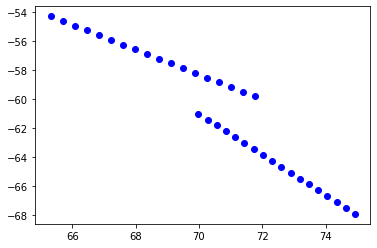

In [18]:
# Visualise current base paths
plt.plot(paths_points[1][:,0], paths_points[1][:,1], 'bo')
plt.show()

In [20]:
# Add measurement gaussian noise
mu, sigma = 0, noise_measure # mean and standard deviation
paths_points_noised = []
for path_points in paths_points:

    noise = np.random.normal(mu, sigma, (path_points.shape[0],2))
    paths_points_noised.append(path_points + noise)

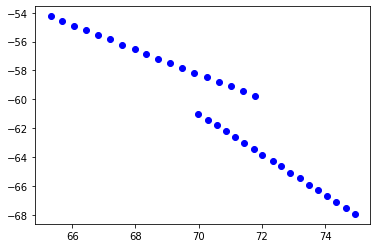

In [21]:
# Visualise current noised base paths
plt.plot(paths_points_noised[0][:,0], paths_points_noised[0][:,1], 'bo')
plt.show()


In [22]:
# Output data in a nice format

# We choose MOT Format
# Lines are ordered per person (first all points for first target, then all lines for second target,...)
# Every line is structured as: index, frame number, person id, x1, y1, x2, y2, ??, ??, ?? (I assume some accuracies and classes are involved)

theFile = open(os.path.join(output_directory, output_filename),"w") 

index = 0
for path in paths_points_noised:
    pedestrian_index = 0
    for point in path:   
        x = point[0]
        y = point[1]
        
        index += 1
        pedestrian_index += 1
        
        # line = "%s,%s,%s,%s\n" % (index, pedestrian_index,x,y)
        line = "%s,%s\n" % (x,y)
        theFile.write(line)   
        

theFile.close() 